# Network Analysis on country level, The Netherlands

Mapping the power grids of the Netherlands to a graph for network analysis purposes such as node- and network-level centralities.

In [1]:
import geopandas as gpd
import pandas as pd
import pyproj
import momepy
import networkx as nx
import osmnx  as ox

/var/folders/bh/hhr2wkwn2ldcpz5w4tgn7sb80000gn/T/ipykernel_84239/3393949879.py:1: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [2]:
CRS = 4326

laagspanningskabel = gpd.read_parquet('../../data/liander/laagspanningskabels.pyarrow')
laagspanningskabel = laagspanningskabel.to_crs(pyproj.CRS.from_epsg(CRS))
laagspanningskabel.head()

,id,geometry
0,3337146,"LINESTRING (5.70785 51.95208, 5.70783 51.95208..."
1,3337161,"LINESTRING (5.70684 51.95345, 5.70683 51.95343..."
2,3337172,"LINESTRING (5.70719 51.95240, 5.70719 51.95240..."
3,3337187,"LINESTRING (5.70743 51.95292, 5.70740 51.95293..."
4,3337202,"LINESTRING (5.70761 51.95377, 5.70760 51.95377..."


In [3]:
reconstructed_lines = gpd.read_parquet('reconstructed_lines_msi_lsv.pyarrow')
reconstructed_lines = reconstructed_lines.to_crs(pyproj.CRS.from_epsg(CRS))
reconstructed_lines.head()

,geometry
0,"LINESTRING (6.48067 51.87102, 6.48077 51.87102)"
1,"LINESTRING (6.48066 51.87102, 6.48077 51.87102)"
2,"LINESTRING (6.48066 51.87102, 6.48077 51.87102)"
3,"LINESTRING (6.02790 51.95575, 6.02801 51.95570)"
4,"LINESTRING (6.02790 51.95575, 6.02801 51.95570)"


In [21]:
full_laagspanningskabel = pd.concat([laagspanningskabel.geometry, reconstructed_lines.geometry])
full_laagspanningskabel.head()

0    LINESTRING (5.70785 51.95208, 5.70783 51.95208...
1    LINESTRING (5.70684 51.95345, 5.70683 51.95343...
2    LINESTRING (5.70719 51.95240, 5.70719 51.95240...
3    LINESTRING (5.70743 51.95292, 5.70740 51.95293...
4    LINESTRING (5.70761 51.95377, 5.70760 51.95377...
Name: geometry, dtype: geometry

In [22]:
gpd_full_laagspanningskabel = gpd.GeoDataFrame(full_laagspanningskabel)
gpd_full_laagspanningskabel = gpd_full_laagspanningskabel.set_geometry('geometry')
gpd_full_laagspanningskabel.head()

,geometry
0,"LINESTRING (5.70785 51.95208, 5.70783 51.95208..."
1,"LINESTRING (5.70684 51.95345, 5.70683 51.95343..."
2,"LINESTRING (5.70719 51.95240, 5.70719 51.95240..."
3,"LINESTRING (5.70743 51.95292, 5.70740 51.95293..."
4,"LINESTRING (5.70761 51.95377, 5.70760 51.95377..."


In [24]:
%%time

G = momepy.gdf_to_nx(gpd_full_laagspanningskabel, approach="primal", length='length')

/opt/homebrew/Caskroom/miniforge/base/envs/tenet-challenge/lib/python3.10/site-packages/momepy/utils.py:247: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_network[length] = gdf_network.geometry.length


CPU times: user 29.7 s, sys: 626 ms, total: 30.3 s
Wall time: 30.4 s


In [31]:
G.order(), G.number_of_edges()

(1125177, 1116945)

In [25]:
positions = {n: [n[0], n[1]] for n in list(G.nodes)}

In [37]:
nodes, edges, W = momepy.nx_to_gdf(G, spatial_weights=True, nodeID='osmid')

/opt/homebrew/Caskroom/miniforge/base/envs/tenet-challenge/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 34331 disconnected components.
  warnings.warn(message)


In [46]:
G_nx = nx.MultiGraph(name='Netherlands', crs=edges.crs)

In [49]:
nodes['x'] = nodes.geometry.apply(lambda x: x.coords[0][0])
nodes['y'] = nodes.geometry.apply(lambda x: x.coords[0][1])

In [50]:
%%time

for nodeId, data in nodes.T.to_dict().items():
    G_nx.add_node(nodeId, **data)

for i, row  in edges.iterrows():
    dict_row  = row.to_dict()
    if 'geometry' in dict_row: del dict_row['geometry']
    G_nx.add_edge(u_for_edge=dict_row['node_start'], v_for_edge=dict_row['node_end'], **dict_row)

CPU times: user 1min 7s, sys: 2.17 s, total: 1min 9s
Wall time: 1min 10s


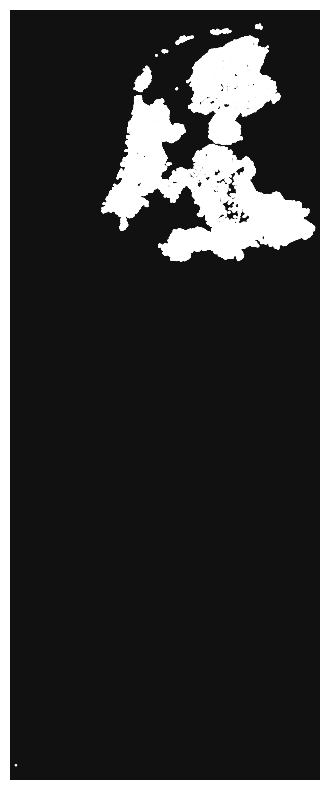

In [51]:
size = 10
ox.plot_graph(G_nx, figsize=(size, size), edge_color='red', node_color='white', node_size=3, filepath='graph.png', save=False);

<Axes: >

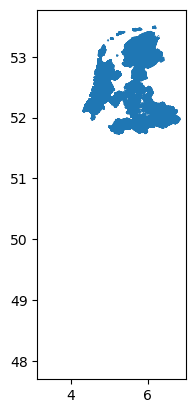

In [52]:
laagspanningskabel.plot()

In [66]:
bounds = gpd_full_laagspanningskabel.bounds
bounds.head()

,minx,miny,maxx,maxy
0,5.707058,51.952076,5.707849,51.952405
1,5.706619,51.953200,5.706844,51.953451
2,5.706249,51.952378,5.707193,51.952705
3,5.706641,51.952918,5.707426,51.953200
4,5.707236,51.953768,5.707608,51.953893


In [70]:
bounds.sort_values(by='miny').head()

,minx,miny,maxx,maxy
873361,3.313748,47.974854,3.313775,47.974855
30795,5.257191,51.739793,5.258514,51.740069
30974,5.257114,51.739799,5.257191,51.739856
30975,5.257114,51.739856,5.257171,51.739948
30973,5.257171,51.739948,5.257180,51.740436


In [79]:
bounds.sort_values(by='miny').index[0]

873361

In [83]:
t = bounds.sort_values(by='miny').index[0]
anomaly = gpd_full_laagspanningskabel.iloc[t, :]
anomaly

geometry    LINESTRING (3.31377 47.97485, 3.31375 47.97485)
Name: 873361, dtype: geometry

In [84]:
x = edges.geometry.intersects(anomaly.geometry)

In [92]:
edge_to_remove = edges[x].iloc[0, :]
edge_to_remove

geometry      LINESTRING (3.313774567407453 47.9748546117035...
length                                                 0.000027
node_start                                              1035511
node_end                                                1035512
Name: 1086912, dtype: object

In [93]:
G_nx.has_edge(edge_to_remove.node_start, edge_to_remove.node_end)

True

In [94]:
G_nx.remove_edge(edge_to_remove.node_start, edge_to_remove.node_end)

In [95]:
G_nx.has_edge(edge_to_remove.node_start, edge_to_remove.node_end)

False

Now we can redo plotting

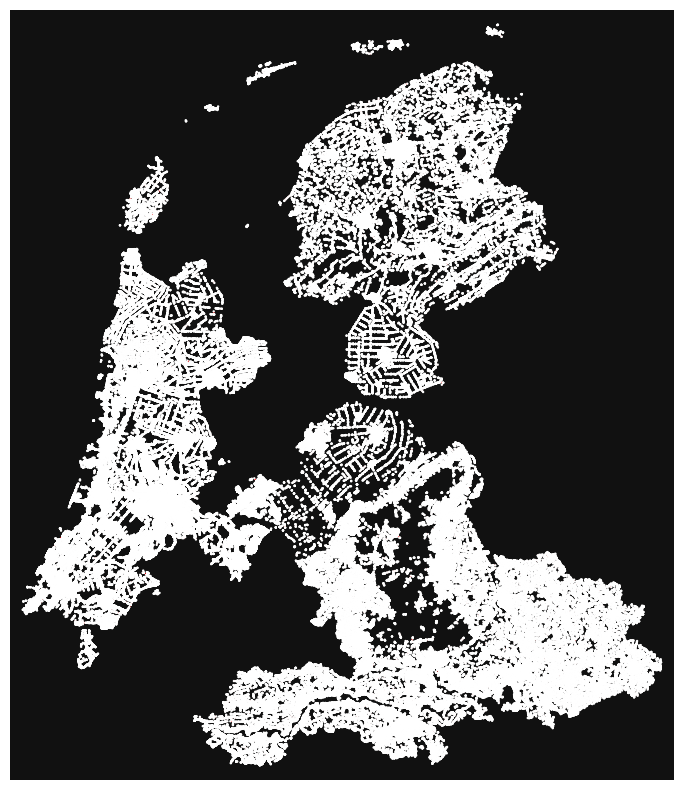

In [96]:
size = 10
ox.plot_graph(G_nx, figsize=(size, size), edge_color='red', node_color='white', node_size=3, filepath='graph.png', save=False);

In [100]:
ox.save_graphml(G_nx, filepath='network_netherlands_gephi.graphml', gephi=True)
ox.save_graphml(G_nx, filepath='network_netherlands.graphml')

In [110]:
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G_nx)

In [114]:
gdf_nodes.to_feather('network_nodes_netherlands.feather')

In [115]:
gdf_edges.to_feather('network_edges_netherlands.feather')

In [ ]:
# loaded_graph = ox.graph_from_gdfs(gdf_nodes, gdf_edges)

In [116]:
dc = nx.degree_centrality(G_nx).values()

In [118]:
degrees = [y for _, y in list(nx.degree(G_nx))]

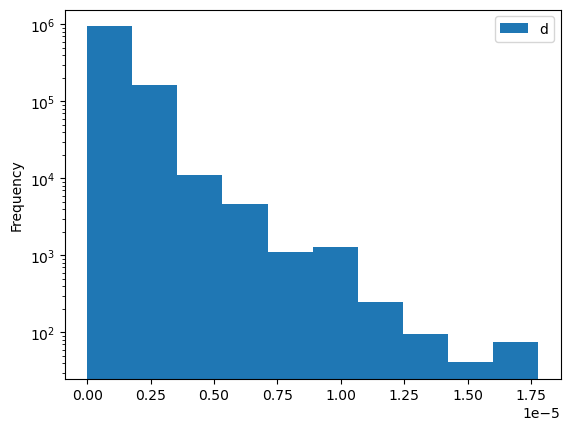

In [122]:
pd.DataFrame({
    'd': dc
}).plot(kind='hist', logy=True);

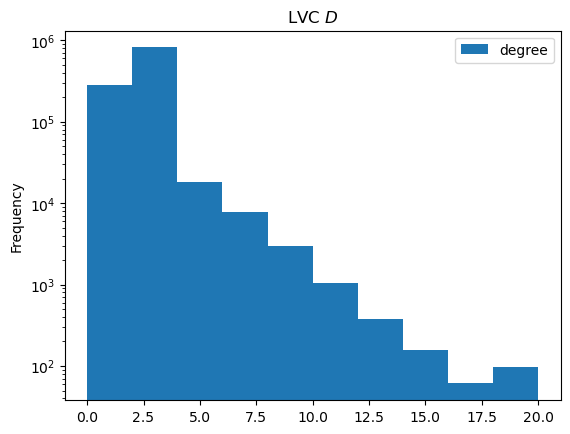

In [124]:
pd.DataFrame({
    'degree': degrees
}).plot(kind='hist', logy=True, title='LVC $D$');